# Data Preprocessing (ETL)


In [25]:
drop_col = ['ID', 'Collection 12 months Medical', 'Accounts Delinquent', 'Payment Plan', 'Application Type']
df_train.drop(columns=drop_col, inplace=True)
df_test.drop(columns=[col for col in drop_col if col in df_test.columns], inplace=True)

In [26]:
df_test.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit
0,17120,10365,16025.082690,59,BAT2575549,12.163926,A,D1,RENT,76468.82190,...,5,f,4469.449851,0.088031,8.425776,0.731797,135,24,475442,4364
1,7133,11650,12615.795600,59,BAT2833642,6.564296,B,E3,MORTGAGE,38079.01344,...,21,w,993.907530,0.041237,6.157008,0.992918,56,1,72412,2573
2,25291,25825,11621.280830,59,BAT1761981,14.729900,A,C3,MORTGAGE,51275.93268,...,23,f,729.113379,0.021745,5.705077,0.281580,3,26,284825,19676
3,30781,9664,15375.823510,59,BAT5341619,10.523767,A,A2,RENT,68867.98965,...,28,w,715.867091,0.092398,2.469688,0.959162,21,32,40842,7226
4,8878,9419,7176.647582,58,BAT4694572,9.997013,C,B3,OWN,91556.85423,...,9,w,248.572854,0.010354,2.127835,0.402315,104,33,90825,26145


In [27]:
# Combine Train & Test for Uniform Processing.
# use keys to track the data.
df_combined = pd.concat([df_train, df_test], axis=0, keys=["train", "test"])

In [28]:
df_train.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Loan Title', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Last week Pay', 'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [29]:
df_combined.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Loan Title', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Last week Pay', 'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [30]:
# Select categorical columns
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

# Prepare summary
encoding_suggestions = []

for col in cat_cols:
    unique_vals = df_train[col].nunique(dropna=False)
    top_cat_pct = df_train[col].value_counts(normalize=True, dropna=False).iloc[0] # The percentage of rows that belong to the most frequent category in a given column.

    if unique_vals <= 10:
        if col in ['Grade']:  # Known ordinal from domain
            encoding_type = "Ordinal Encoding"
        else:
            encoding_type = "One-Hot Encoding"
    elif 10 < unique_vals <= 50:
        encoding_type = "Label Encoding"
    elif unique_vals > 50:
        encoding_type = "Frequency Encoding / Target Encoding"
    else:
        encoding_type = "Review Manually"

    dominance_flag = "Dominant Category" if top_cat_pct > 0.95 else ""
    
    encoding_suggestions.append({
        "Column": col,
        "Unique Values": unique_vals,
        "Top Category %": round(top_cat_pct * 100, 2),
        "Suggested Encoding": encoding_type,
        "Note": dominance_flag
    })

# Convert to DataFrame
encoding_df = pd.DataFrame(encoding_suggestions).sort_values(by="Unique Values")

In [31]:
encoding_df

,Column,Unique Values,Top Category %,Suggested Encoding,Note
6,Initial List Status,2,53.81,One-Hot Encoding,
3,Employment Duration,3,53.88,One-Hot Encoding,
4,Verification Status,3,48.97,One-Hot Encoding,
1,Grade,7,28.29,Ordinal Encoding,
2,Sub Grade,35,6.61,Label Encoding,
0,Batch Enrolled,41,5.37,Label Encoding,
5,Loan Title,109,45.55,Frequency Encoding / Target Encoding,


In [32]:
# Implemnting encoding

from sklearn.preprocessing import LabelEncoder

# --- 1. Ordinal Encoding for 'Grade'
grade_order = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
df_combined["Grade"] = df_combined["Grade"].map(grade_order)

# --- 2. Label Encoding for 'Sub Grade' and 'Batch Enrolled'
label_cols = ["Sub Grade", "Batch Enrolled"]
le = LabelEncoder()
for col in label_cols:
    df_combined[col] = le.fit_transform(df_combined[col])

# --- 3. Frequency Encoding for 'Loan Title'
freq_map = df_combined["Loan Title"].value_counts().to_dict()
df_combined["Loan Title"] = df_combined["Loan Title"].map(freq_map)

# --- 4. One-Hot Encoding for 'Initial List Status', 'Employment Duration', 'Verification Status'
one_hot_cols = ["Initial List Status", "Employment Duration", "Verification Status"]
df_combined = pd.get_dummies(df_combined, columns=one_hot_cols, drop_first=True)

In [33]:
df_combined.head()

Loan Amount  Funded Amount  Funded Amount Investor  Term  \
train 0      10000.0        32112.8             12329.36286    59   
      1       4485.1        11940.0             12191.99692    59   
      2      28276.0         9311.0             21603.22455    59   
      3      11170.0         6954.0             17877.15585    59   
      4      16890.0        13226.0             13539.92667    59   

         Batch Enrolled  Interest Rate  Grade  Sub Grade  Home Ownership  \
train 0              16      11.135007      2         13    168296.71763   
      1               4      12.237563      3         17     39833.92100   
      2              11      12.545884      6         18     91506.69105   
      3              15      16.731201      3         12    108286.57590   
      4              32      15.008300      3         18     44234.82545   

         Loan Title  ...  Last week Pay  Total Collection Amount  \
train 0        4688  ...             49                       31   
      1       37100  ...            109                       53   
      2        4688  ...             66                       34   
      3       37100  ...             39                       40   
      4       42084  ...             18                      430   

         Total Current Balance  Total Revolving Credit Limit  Loan Status  \
train 0               311301.0                        6619.0          0.0   
      1               182610.0                       20885.0          0.0   
      2                89801.0                       26155.0          0.0   
      3                18215.3                       60214.0          0.0   
      4               126029.0                       22579.0          0.0   

         Initial List Status_w  Employment Duration_OWN  \
train 0                   True                    False   
      1                  False                    False   
      2                   True                    False   
      3                   True                    False   
      4                   True                    False   

         Employment Duration_RENT  Verification Status_Source Verified  \
train 0                     False                                False   
      1                      True                                 True   
      2                     False                                 True   
      3                     False                                 True   
      4                     False                                 True   

         Verification Status_Verified  
train 0                         False  
      1                         False  
      2                         False  
      3                         False  
      4                         False  

[5 rows x 32 columns]

In [34]:
df_combined.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Home Ownership', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Total Received Interest', 'Total Received Late Fee',
       'Recoveries', 'Collection Recovery Fee', 'Last week Pay',
       'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status', 'Initial List Status_w',
       'Employment Duration_OWN', 'Employment Duration_RENT',
       'Verification Status_Source Verified', 'Verification Status_Verified'],
      dtype='object')

In [35]:
# Restore train and test from MultiIndex
df_train_encoded = df_combined.loc["train"].copy()
df_test_encoded = df_combined.loc["test"].copy()

In [36]:
print ("Loan Status" in df_train_encoded.columns)

True


In [37]:
print ("Loan Status" in df_test_encoded.columns)

True


In [39]:
df_test_encoded["Loan Status"].nunique()

0

In [40]:
df_test_encoded.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Home Ownership,Loan Title,...,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status,Initial List Status_w,Employment Duration_OWN,Employment Duration_RENT,Verification Status_Source Verified,Verification Status_Verified
0,17120.0,10365.0,16025.082690,59,18,12.163926,1,15,76468.82190,3293,...,135,24,475442.0,4364.0,NaN,False,False,True,True,False
1,7133.0,11650.0,12615.795600,59,20,6.564296,2,22,38079.01344,42084,...,56,1,72412.0,2573.0,NaN,True,False,False,True,False
2,25291.0,25825.0,11621.280830,59,5,14.729900,1,12,51275.93268,37100,...,3,26,284825.0,19676.0,NaN,False,False,False,True,False
3,30781.0,9664.0,15375.823510,59,32,10.523767,1,1,68867.98965,4688,...,21,32,40842.0,7226.0,NaN,True,False,True,False,True
4,8878.0,9419.0,7176.647582,58,29,9.997013,3,7,91556.85423,37100,...,104,33,90825.0,26145.0,NaN,True,True,False,False,True


In [41]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28913 entries, 0 to 28912
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Loan Amount                          28913 non-null  float64
 1   Funded Amount                        28913 non-null  float64
 2   Funded Amount Investor               28913 non-null  float64
 3   Term                                 28913 non-null  int64  
 4   Batch Enrolled                       28913 non-null  int64  
 5   Interest Rate                        28913 non-null  float64
 6   Grade                                28913 non-null  int64  
 7   Sub Grade                            28913 non-null  int64  
 8   Home Ownership                       28913 non-null  float64
 9   Loan Title                           28913 non-null  int64  
 10  Debit to Income                      28913 non-null  float64
 11  Delinquency - two years          

🎯 Original Class Distribution:
Counter({0.0: 61222, 1.0: 6241})

📈 After SMOTE:
Counter({0.0: 61222, 1.0: 61222})

📉 After NearMiss:
Counter({0.0: 6241, 1.0: 6241})

📊 Class Distribution Comparison:



,Non-Defaulter (0),Defaulter (1)
Original,61222,6241
SMOTE,61222,61222
NearMiss,6241,6241


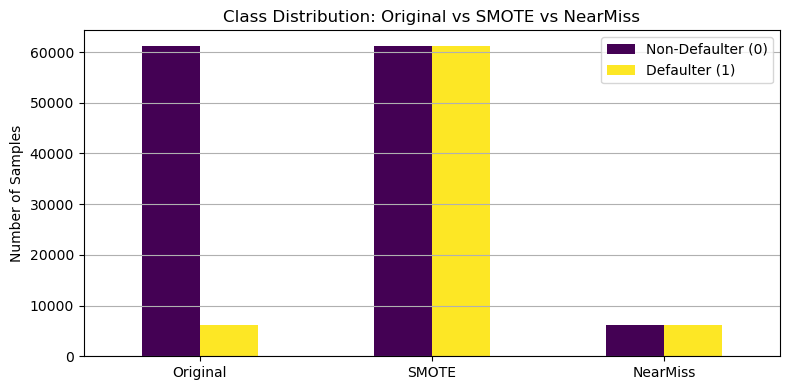

In [48]:
# --- 1. Imports ---
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# --- 2. Prepare Features and Target ---
X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]
X_kaggle_test = df_test_encoded.drop(columns=["Loan Status"])

print("🎯 Original Class Distribution:")
print(Counter(y))

# --- 3. Apply SMOTE ---
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("\n📈 After SMOTE:")  
print(Counter(y_smote))

# --- 4. Apply NearMiss ---
nearmiss = NearMiss(version=1)
X_nm, y_nm = nearmiss.fit_resample(X, y)
print("\n📉 After NearMiss:")
print(Counter(y_nm))

# --- 5. Compare in Table ---
comparison_df = pd.DataFrame({
    "Original": pd.Series(Counter(y)),
    "SMOTE": pd.Series(Counter(y_smote)),
    "NearMiss": pd.Series(Counter(y_nm))
}).T
comparison_df.columns = ["Non-Defaulter (0)", "Defaulter (1)"]
print("\n📊 Class Distribution Comparison:\n")
display(comparison_df)

# --- 6. Plotting ---
comparison_df.plot(kind="bar", figsize=(8, 4), colormap="viridis")
plt.title("Class Distribution: Original vs SMOTE vs NearMiss")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()